In [16]:
import pickle,itertools,sys,pdb,pdb
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import graphviz
import multiprocessing
from alphamind.data.processing import factor_processing
from alphamind.data.standardize import standardize
from alphamind.data.winsorize import winsorize_normal
from ultron.factor.genetic.geneticist.genetic import Gentic
import warnings
warnings.filterwarnings("ignore")

In [17]:
## IC 方法
def websim_weighted(factor_data, total_data, factor_sets):
    factor_data = factor_data.copy()
    factor_data = factor_data.reset_index().sort_values(['trade_date','code'])
    factor_data = factor_data.fillna(0)
    score = np.corrcoef(factor_data['transformed'].values, total_data.sort_values(
        ['trade_date','code'])['ret'].values)[0,1]
    return abs(score)

In [18]:
with open('factor_data.pkl','rb') as file2:
    total_data = pickle.load(file2)
    
total_data = total_data.sort_values(by=['trade_date','code'],ascending=True)
factor_sets = [i for i in list(set(total_data.columns)) if i not in ['trade_date','code','ret']]
ndiff_field = [i for i in list(set(total_data.columns)) if i not in factor_sets]
#数据预处理
alpha_res = []
grouped = total_data.groupby(['trade_date'])
for k, g in grouped:
    ret_preprocess = factor_processing(g[factor_sets].fillna(0).values,
                                       pre_process=[winsorize_normal, standardize])
    f = pd.DataFrame(ret_preprocess, columns=factor_sets)
    for k in ndiff_field:
        f[k] = g[k].values
    alpha_res.append(f)
alpha_data = pd.concat(alpha_res)

In [19]:
#覆盖率低于65%删除
def nan_rate(params):
    name = params['name']
    data = params['data']
    coverage_rate  =  1 - np.isnan(data).sum()/ len(data)
    return {'rate':coverage_rate,'name':name}
factor_data_list = []
for name in factor_sets:
    factor_data_list.append({'name':name,'data':alpha_data[name].values})
    
with multiprocessing.Pool(processes=4) as p:
    values_list = p.map(nan_rate, factor_data_list)
factor_rate = pd.DataFrame(values_list)
factor_rate = factor_rate[factor_rate.rate > 0.65]
alpha_data = alpha_data[list(factor_rate.name) + ndiff_field]

In [20]:
#移动收益率
def shift_ret(data):
    data = data.sort_values(by='trade_date',ascending=True)
    data['ret'] = data['ret'].shift(-1)
    return data.dropna(subset=['ret'])
now_data = alpha_data.groupby(['code']).apply(shift_ret)

In [21]:
alpha_data = now_data.set_index('code').reset_index().sort_values(by=['trade_date','code'],ascending=True)

In [28]:
gentic = Gentic(population_size=30, tournament_size = 7, 
                init_depth=(4, 5),
                generations=3, n_jobs = 8, stopping_criteria=100, verbose=1,
                factor_sets = factor_sets,
                fitness=websim_weighted)

gentic.train(total_data=alpha_data)
result = gentic._run_details

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   13.7s remaining:   41.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   16.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   10.0s remaining:   29.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   12.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.2s finished


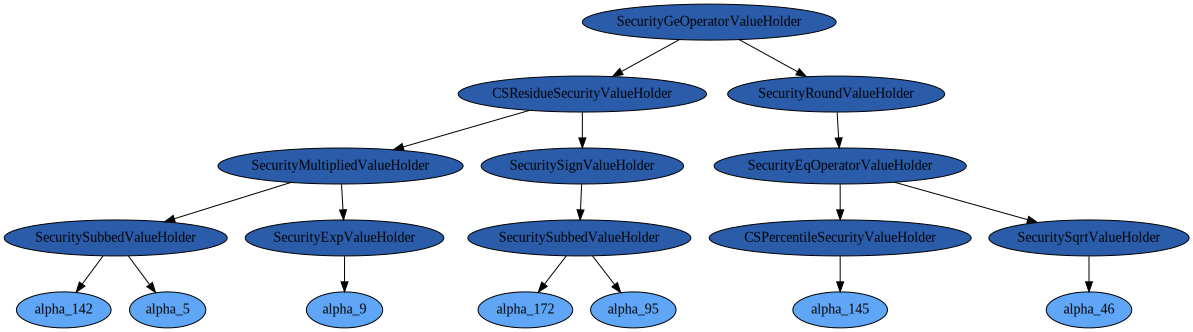

In [29]:
graphviz.Source(result['best_programs'][-1][-1].export_graphviz())